# Searchlight hyperalignment

In this example, we align the data of the 1st subject (`sids[0]`) to the data of the 2nd subject (`sids[1]`).

In [1]:
%%capture
%pip install -U neuroboros hyperalignment

In [2]:
import numpy as np
import neuroboros as nb
import hyperalignment as ha
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [3]:
dset = nb.Forrest()
sids = dset.subjects

We use the first half of the movie (runs 1–4) as training data, and the second half of the movie as test data.

In [4]:
X_train, X_test = {}, {}
Y_train, Y_test = {}, {}
for lr in 'lr':
    X_train[lr] = np.concatenate([dset.get_data(sids[0], 'forrest', run_, lr) for run_ in [1, 2, 3, 4]], axis=0)
    Y_train[lr] = np.concatenate([dset.get_data(sids[1], 'forrest', run_, lr) for run_ in [1, 2, 3, 4]], axis=0)
    X_test[lr] = np.concatenate([dset.get_data(sids[0], 'forrest', run_, lr) for run_ in [5, 6, 7, 8]], axis=0)
    Y_test[lr] = np.concatenate([dset.get_data(sids[1], 'forrest', run_, lr) for run_ in [5, 6, 7, 8]], axis=0)

`ha.searchlight_procrustes` performs the classic Procrustes searchlight hyperalignment.
It returns a transformation matrix `W` that can transform the 1st subject's data to the 2nd subject's space.

In [5]:
radius = 20
Ws = {}
for lr in 'lr':
    sls, dists = nb.sls(lr, radius, return_dists=True)
    W = ha.searchlight_procrustes(
        X_train[lr], Y_train[lr], sls, dists, radius)
    Ws[lr] = W

We use inter-subject correlation to evaluate performance.
In this case, it's the correlation between the corresponding time series of the two subjects.
First, we compute the correlations based on anatomically-aligned data, which are based on time series of cortical vertices at the same anatomical location.

In [6]:
r_train0 = np.concatenate([
    np.mean(zscore(X_train[lr], axis=0) * zscore(Y_train[lr], axis=0), axis=0)
    for lr in 'lr'])
r_test0 = np.concatenate([
    np.mean(zscore(X_test[lr], axis=0) * zscore(Y_test[lr], axis=0), axis=0)
    for lr in 'lr'])

In [7]:
np.set_printoptions(formatter={'float': lambda x: f'{x:7.4f}'})
nb.percentile(r_train0)
nb.percentile(r_test0)

[-0.1607 -0.0165  0.0011  0.0153  0.0288  0.0429  0.0608  0.0833  0.1240
  0.1980  0.6869]
[-0.2561 -0.0149  0.0030  0.0160  0.0282  0.0424  0.0594  0.0840  0.1252
  0.2105  0.6171]


/Users/feilong/github/neuroboros/src/neuroboros/utils/__init__.py:67: UserWarning: 69 values out of 19341 are NaNs.
  warnings.warn(f'{count} values out of {data.size} are NaNs.')
/Users/feilong/github/neuroboros/src/neuroboros/utils/__init__.py:67: UserWarning: 90 values out of 19341 are NaNs.
  warnings.warn(f'{count} values out of {data.size} are NaNs.')


Using the transformation matrices, we can project the 1st subject's data to the 2nd subject's space.
The resulting data matrices can be considered as predicted data matrix for the 2nd subject based on hyperaligned data.

In [8]:
Yhat_train, Yhat_test = {}, {}
for lr in 'lr':
    Yhat_train[lr] = X_train[lr] @ Ws[lr]
    Yhat_test[lr] = X_test[lr] @ Ws[lr]

Inter-subject correlation after hyperalignment is higher, suggesting better alignment between subjects.

In [9]:
r_train = np.concatenate([
    np.mean(zscore(Yhat_train[lr], axis=0) * zscore(Y_train[lr], axis=0), axis=0)
    for lr in 'lr'])
r_test = np.concatenate([
    np.mean(zscore(Yhat_test[lr], axis=0) * zscore(Y_test[lr], axis=0), axis=0)
    for lr in 'lr'])

In [10]:
nb.percentile(r_train)
nb.percentile(r_test)

[ 0.0843  0.1583  0.1741  0.1856  0.1963  0.2079  0.2215  0.2414  0.2778
  0.3487  0.7144]
[-0.1136 -0.0099  0.0087  0.0243  0.0410  0.0602  0.0855  0.1245  0.1921
  0.2904  0.6160]


/Users/feilong/github/neuroboros/src/neuroboros/utils/__init__.py:67: UserWarning: 60 values out of 19341 are NaNs.
  warnings.warn(f'{count} values out of {data.size} are NaNs.')
/Users/feilong/github/neuroboros/src/neuroboros/utils/__init__.py:67: UserWarning: 71 values out of 19341 are NaNs.
  warnings.warn(f'{count} values out of {data.size} are NaNs.')


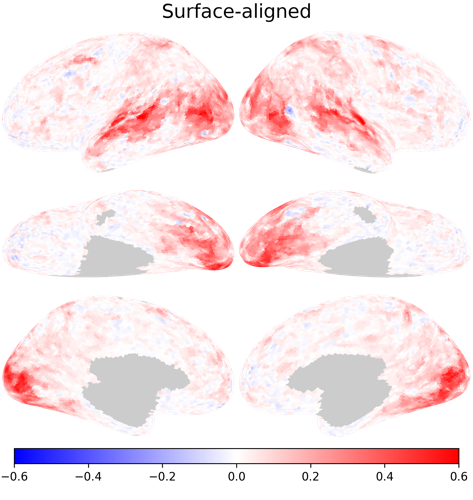

In [11]:
vmax = 0.6
kwargs = dict(cmap='bwr', vmax=vmax, vmin=-vmax)
nb.plot(r_test0, fn='aa.png', title='Surface-aligned', **kwargs)

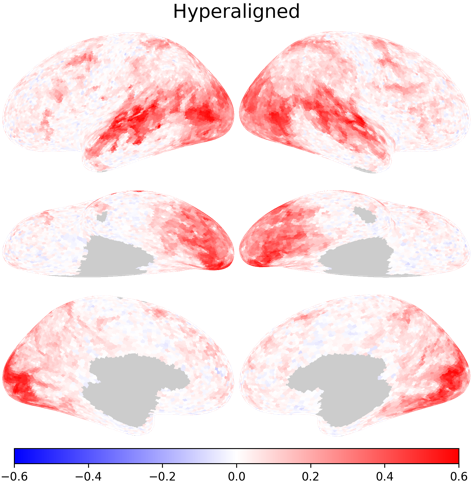

In [12]:
vmax = 0.6
nb.plot(r_test, fn='ha.png', title='Hyperaligned', **kwargs)

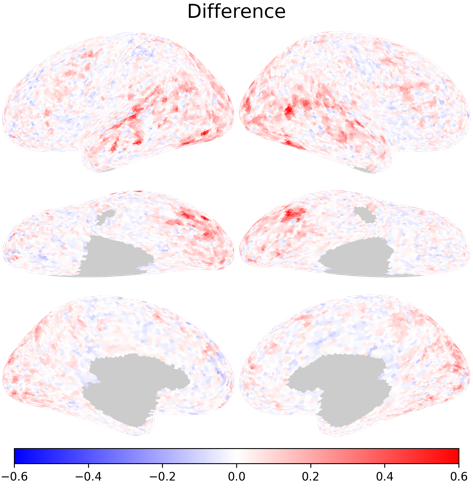

In [13]:
vmax = 0.6
nb.plot(r_test - r_test0, title='Difference', fn='diff.png', **kwargs)

In the scatterplot, most of the points are above the diagonal, which means inter-subject correlation has improved with hyperalignment.

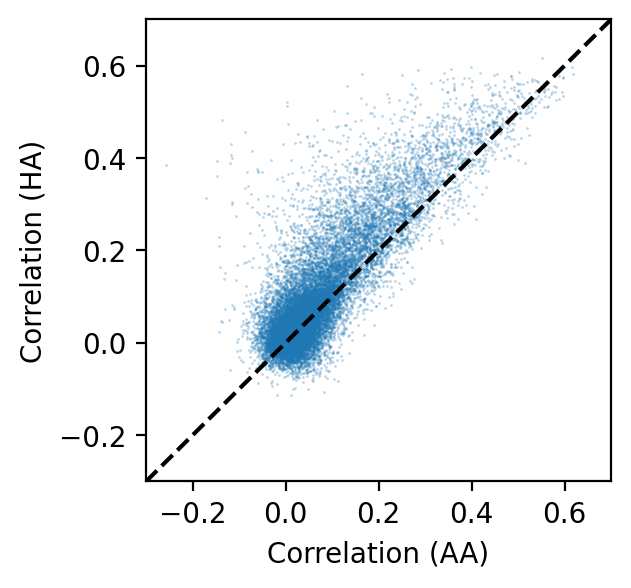

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)
lim = [-0.3, 0.7]
ax.plot(lim, lim, 'k--')
ax.scatter(r_test0, r_test, s=1, linewidth=0, alpha=0.3)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_xlabel('Correlation (AA)')
ax.set_ylabel('Correlation (HA)')
plt.show()